# Customer Churn Prediction

## Import Necessary Libraries

In [1]:
# To analyze data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
import os
sns.set(style = 'white')

In [2]:
# For model creation and feature analyzation
from xgboost import XGBClassifier  # XGBoost classifier for building the main model
import xgboost
from numpy import loadtxt
from xgboost import plot_tree # Plot the decision tree
import graphviz # Plot the decision tree
from sklearn.model_selection import train_test_split  # Split data into training and test sets
from sklearn.metrics import accuracy_score, roc_auc_score # Metrics to evaluate model performance
from sklearn.model_selection import RandomizedSearchCV  # Optimize model parameters
from sklearn.metrics import roc_curve, auc  # Compute ROC curve and AUC for model evaluation
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Data scaling and encoding categorical features
from sklearn.compose import ColumnTransformer  # Apply transformers to different columns of a dataframe
from sklearn.pipeline import Pipeline  # Pipeline to execute steps in sequence
from sklearn.cluster import KMeans  # Clustering algorithm for segmentation
import shap  # SHAP for model explainability and to understand the impact of features

## Read and Analyze Dataset

### Read Dataset and Look at First Entries

In [3]:
df = pd.read_csv('.\input\WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Check Value Types

In [5]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## Data Preprocessing

### Convert Total Charges to Numerical Data Type

In [7]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### Preprocess Our Target Variable

In [8]:
#Removing missing values 
df.dropna(inplace = True)
#Remove customer IDs from the data set
df2 = df.iloc[:,1:]
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,0,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,False,True,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,0,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,1,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


## Analyze Features

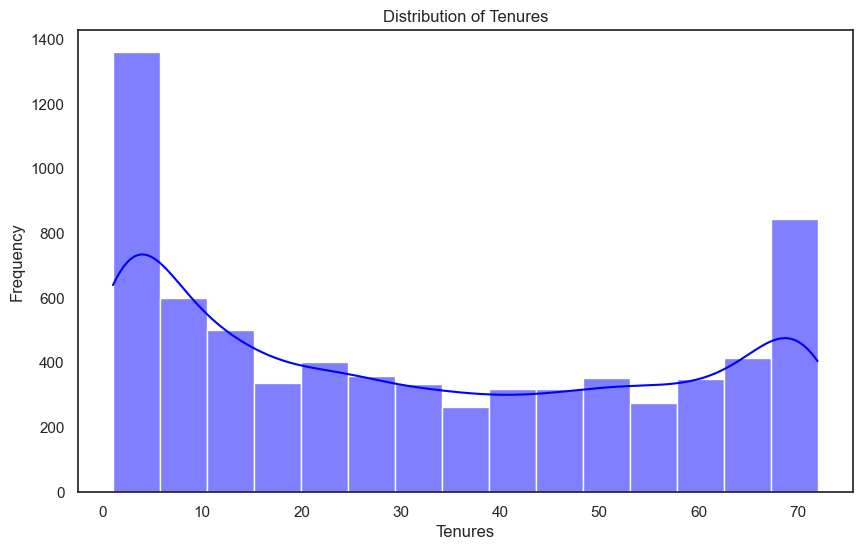

In [9]:
# Plotting the distribution of monthly charges
plt.figure(figsize=(10, 6))
sns.histplot(df_dummies['tenure'], kde=True, color='blue')
plt.title('Distribution of Tenures')
plt.xlabel('Tenures')
plt.ylabel('Frequency')
plt.show()

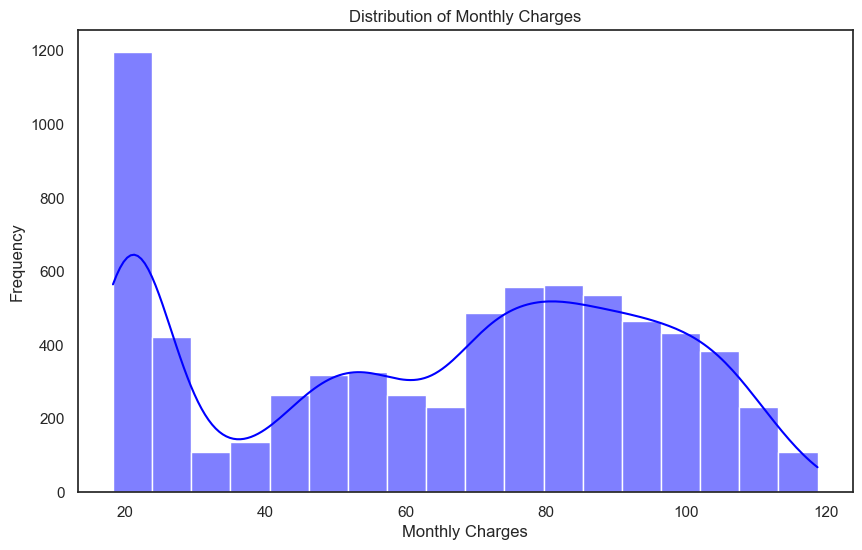

In [10]:
# Plotting the distribution of monthly charges
plt.figure(figsize=(10, 6))
sns.histplot(df_dummies['MonthlyCharges'], kde=True, color='blue')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.show()

## Analyze Customer Features

C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\1776013029.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


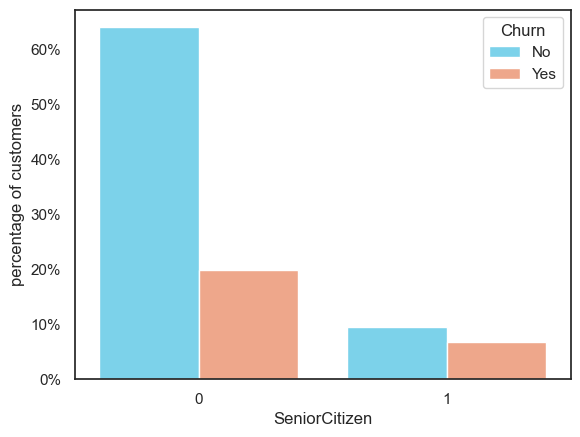

In [11]:
custom_palette = ['#6ADDFC', '#FFA07A']  # Define custom presentation colors

def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    # Group by the feature and Churn, then calculate value counts
    g = df.groupby([feature, "Churn"]).size().reset_index(name='count')
    # Calculate the percentage
    g[axis_name] = g['count'] / len(df)
    
    # Create the bar plot
    if orient == 'v':
        ax = sns.barplot(x=feature, y=axis_name, hue='Churn', data=g, orient=orient, palette=custom_palette)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x=axis_name, y=feature, hue='Churn', data=g, orient=orient, palette=custom_palette)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    
    plt.show()

# Example usage
barplot_percentages('SeniorCitizen')

C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


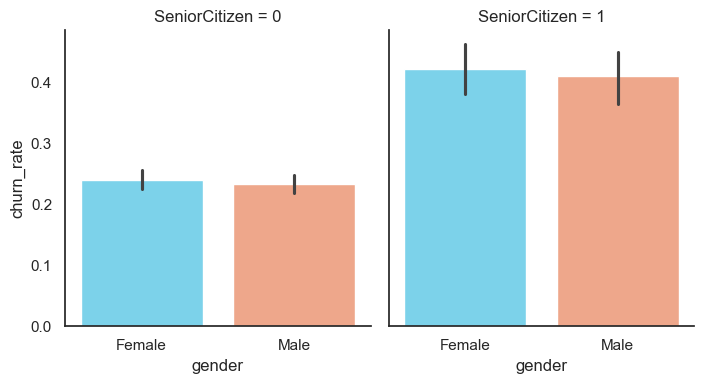

In [12]:
df['churn_rate'] = df['Churn'].replace("No", 0).replace("Yes", 1)
# Create the FacetGrid plot
g = sns.FacetGrid(df, col="SeniorCitizen", height=4, aspect=.9)
g.map_dataframe(sns.barplot, x="gender", y="churn_rate", palette=custom_palette, order=['Female', 'Male'])

C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\3420216218.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[0].set_yticklabels(['{:,.0%}'.format(y) for y in axis[0].get_yticks()])
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\3420216218.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[1].set_yticklabels(['{:,.0%}'.format(y) for y in axis[1].get_yticks()])


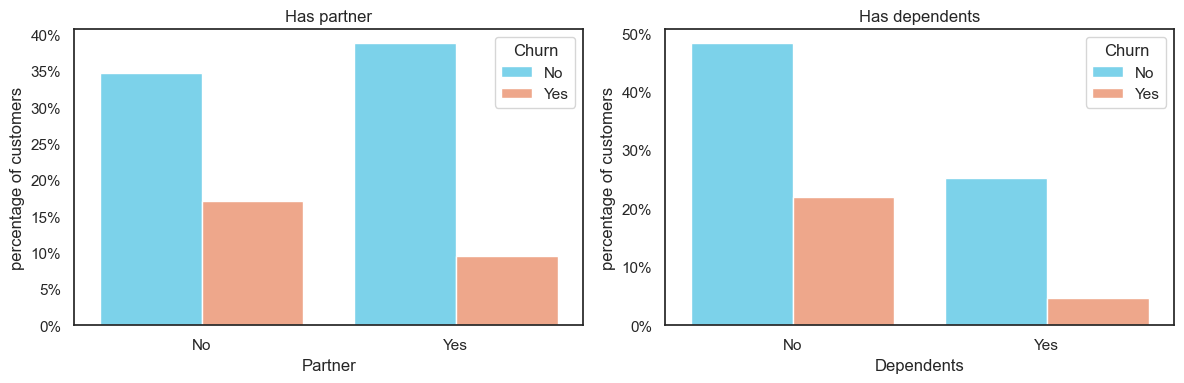

In [13]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
axis[0].set_title("Has partner")
axis[1].set_title("Has dependents")
axis_y = "percentage of customers"

# Plot Partner column
gp_partner = df.groupby(['Partner', 'Churn']).size().reset_index(name='count')
gp_partner[axis_y] = gp_partner['count'] / len(df)
sns.barplot(x='Partner', y=axis_y, hue='Churn', data=gp_partner, ax=axis[0], palette=custom_palette)
axis[0].set_yticklabels(['{:,.0%}'.format(y) for y in axis[0].get_yticks()])

# Plot Dependents column
gp_dep = df.groupby(['Dependents', 'Churn']).size().reset_index(name='count')
gp_dep[axis_y] = gp_dep['count'] / len(df)
sns.barplot(x='Dependents', y=axis_y, hue='Churn', data=gp_dep, ax=axis[1], palette=custom_palette)
axis[1].set_yticklabels(['{:,.0%}'.format(y) for y in axis[1].get_yticks()])

plt.tight_layout()
plt.show()

C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\1776013029.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


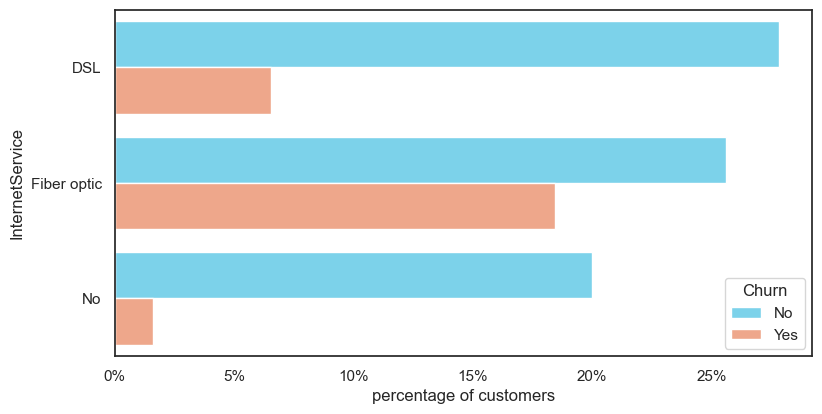

In [14]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("InternetService", orient="h")

C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:854: UserWarni

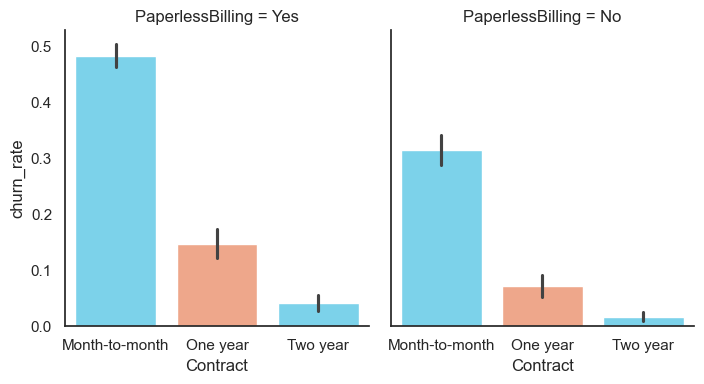

In [15]:
g = sns.FacetGrid(df, col="PaperlessBilling", height=4, aspect=.9)
ax = g.map(sns.barplot, "Contract", "churn_rate", palette=custom_palette, order= ['Month-to-month', 'One year', 'Two year'])

C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\1776013029.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


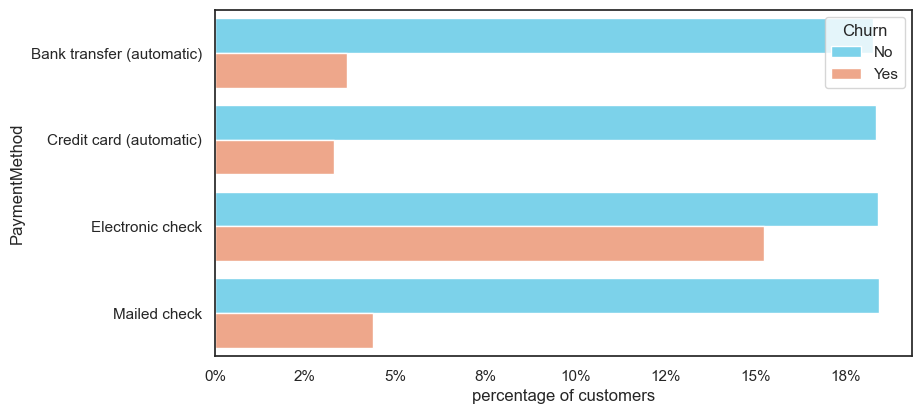

In [16]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("PaymentMethod", orient='h')

### Look at Churn Rate

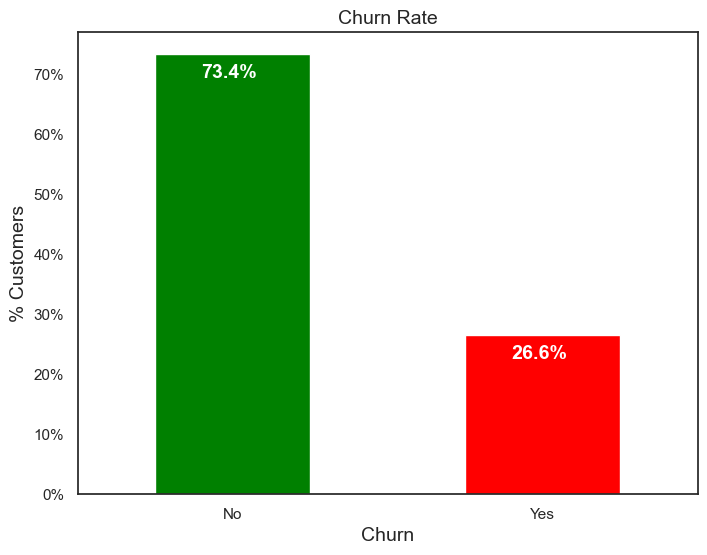

In [17]:
colors = ['green', 'red']
ax = (df['Churn'].value_counts()*100.0 /len(df)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            color='white',
           weight = 'bold',
           size = 14)

## Show Correlation of Target Variable 'Churn' to Features

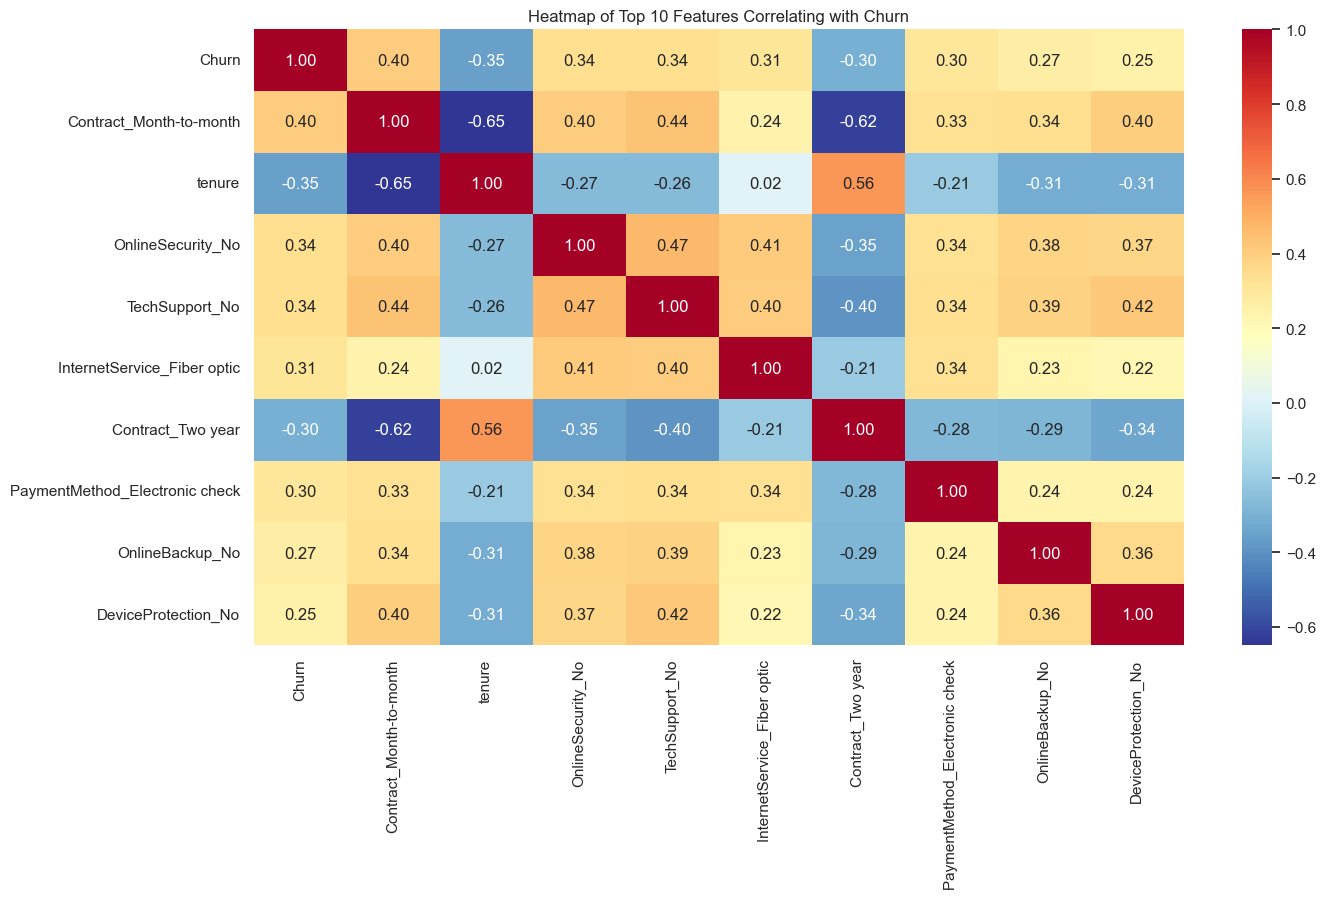

In [18]:
# Calculate the correlation matrix
corr = df_dummies.corr()

# Get the correlations with the target variable 'Churn'
churn_corr = corr['Churn']

# Select the top 10 features correlated with 'Churn', including 'Churn' itself
top_10_features = churn_corr.abs().sort_values(ascending=False).head(10).index

# Create a subset of the correlation matrix for these features
top_10_corr = df_dummies[top_10_features].corr()

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(top_10_corr, annot=True, fmt='.2f', cmap='RdYlBu_r', cbar=True)
plt.title('Heatmap of Top 10 Features Correlating with Churn')
plt.show()

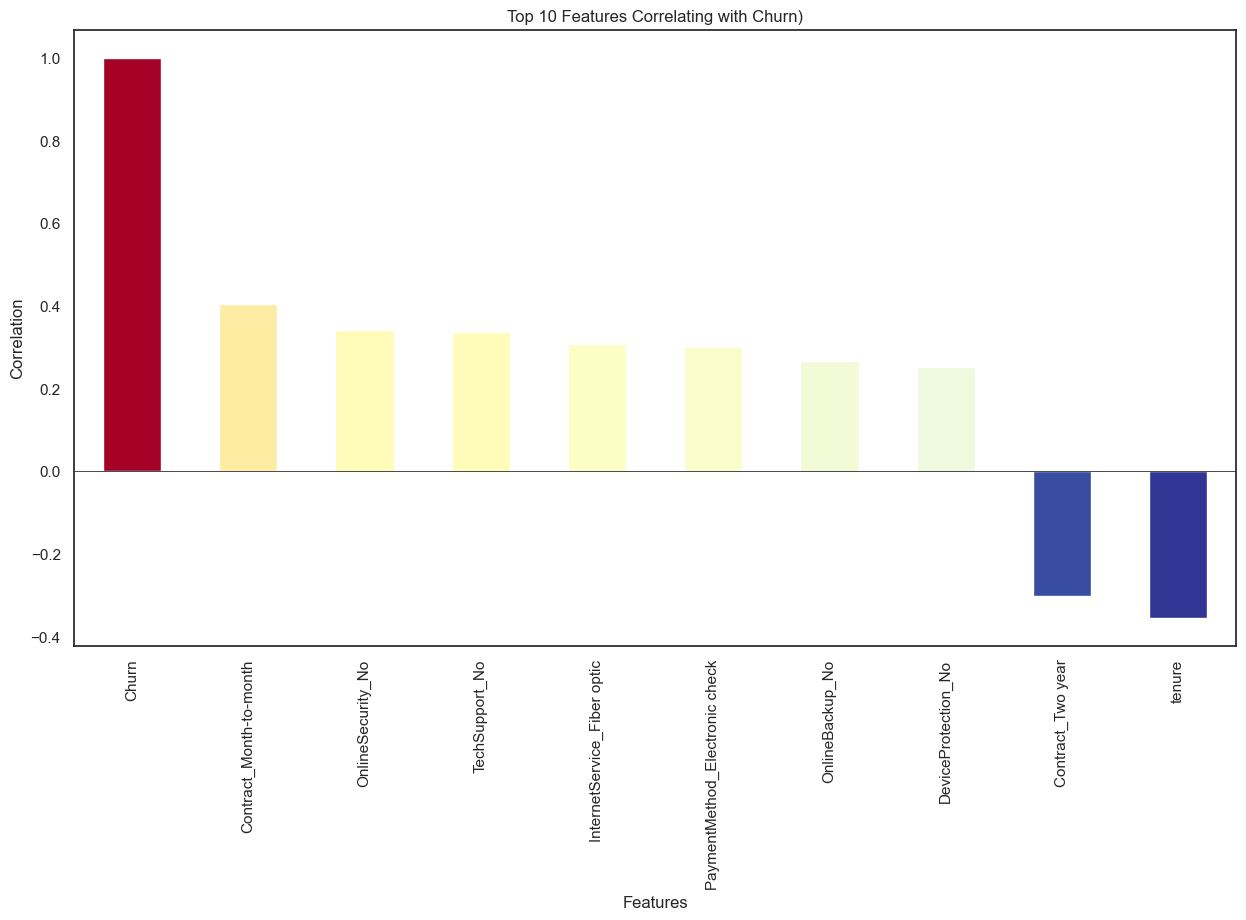

In [19]:
# Get correlation values for the top 10 features
correlation_values = churn_corr.loc[top_10_features].sort_values(ascending=False)

# Plot the bar plot
plt.figure(figsize=(15, 8))

# Apply a heatmap-like color scheme
colors = plt.cm.RdYlBu_r((correlation_values - correlation_values.min()) / (correlation_values.max() - correlation_values.min()))

correlation_values.plot(kind='bar', color=colors)
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Top 10 Features Correlating with Churn)')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.show()

# Create Model for Churn Prediction

In [20]:
# Preparing the feature matrix and target vector
X = df_dummies.drop('Churn', axis=1)
y = df_dummies['Churn']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

### Find Best Training Parameters

In [21]:
# Setting up the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1]
}

# Creating the GridSearchCV object
grid= RandomizedSearchCV(XGBClassifier(), param_grid, cv=5, scoring='roc_auc')

# Fit on data
grid.fit(X_train, y_train)

# Train model with best hyperparameters
best_model = grid.best_estimator_

ROC AUC Score: 0.8619304288381143


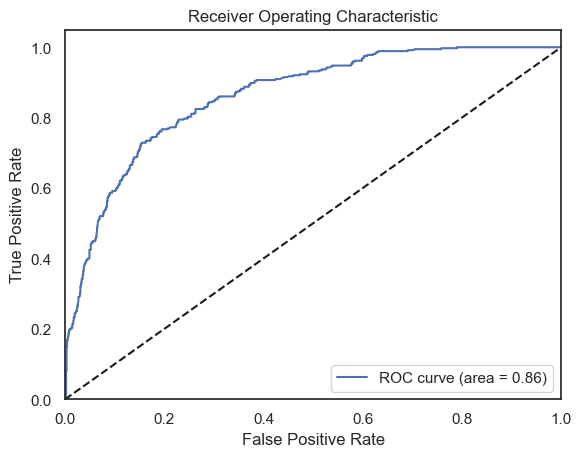

In [22]:
# Predict probabilities for the test set
y_probs = best_model.predict_proba(X_test)[:, 1]  # probability estimates for the positive class

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [49]:
# Plot example Tree
plot_tree(best_model)
fig = plt.gcf()
fig.set_size_inches(250, 100)
fig.savefig('tree.png')

### SHAP Analysis of Features

In [24]:
# Create the SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

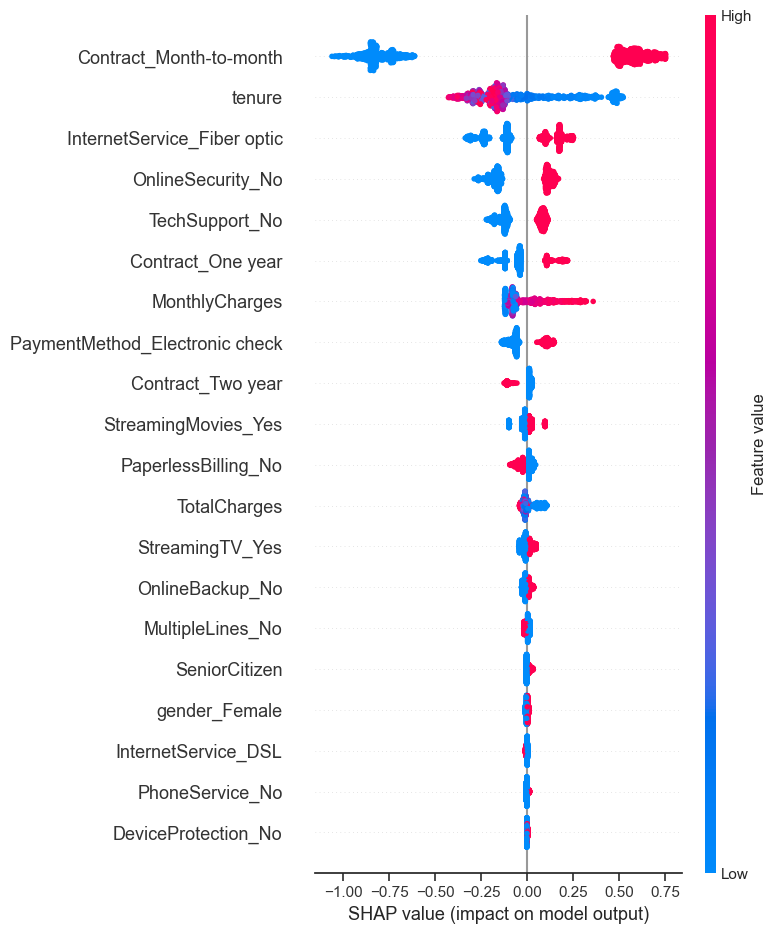

In [25]:
shap.summary_plot(shap_values, X_test, plot_type="dot")

## Clustering

In [26]:
from sklearn.cluster import KMeans

df_churn = df_dummies.drop(df_dummies[df_dummies.Churn == 0].index)

# Preparing the feature matrix and target vector
X_cluster = df_churn.drop('Churn', axis=1)
y_cluster = df_churn['Churn']

C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

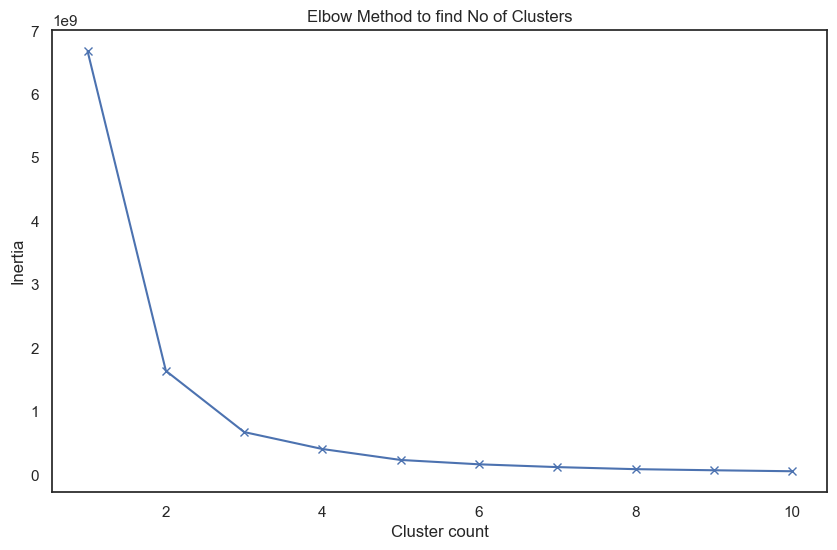

In [27]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Plot zur Bestimmung der optimalen Clusteranzahl
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Cluster count')
plt.ylabel('Inertia')
plt.title('Elbow Method to find No of Clusters')
plt.show()

In [28]:
# k-means clustering to sort customers into x different groups
kmeans = KMeans(n_clusters=3, random_state=99)
clusters = kmeans.fit_predict(X_cluster)

C:\Users\Janika\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [29]:
# Add Cluster Number to df
df_churn['Cluster'] = clusters

In [30]:
cluster_centers = kmeans.cluster_centers_

# Create a DataFrame to store cluster centers with feature names
cluster_centers_df = pd.DataFrame(cluster_centers, columns=X_cluster.columns)

In [31]:
# Add a column for cluster labels
cluster_centers_df['Cluster'] = range(0, len(cluster_centers))

# Display cluster centers
print(cluster_centers_df)

   SeniorCitizen     tenure  MonthlyCharges  TotalCharges  gender_Female  \
0       0.313636  57.286364      100.765000   5780.754318       0.431818   
1       0.220810   6.632248       66.408022    434.219500       0.513106   
2       0.330769  32.435897       85.525256   2678.150256       0.507692   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  ...  \
0     0.568182    0.354545     0.645455       0.772727        0.227273  ...   
1     0.486894    0.734710     0.265290       0.845115        0.154885  ...   
2     0.492308    0.505128     0.494872       0.792308        0.207692  ...   

   Contract_Month-to-month  Contract_One year  Contract_Two year  \
0                 0.468182           0.363636           0.168182   
1                 0.972200           0.023828           0.003971   
2                 0.841026           0.143590           0.015385   

   PaperlessBilling_No  PaperlessBilling_Yes  \
0             0.195455              0.804545   
1        

C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], pal

C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], pal

C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], pal

C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\868244317.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], pal

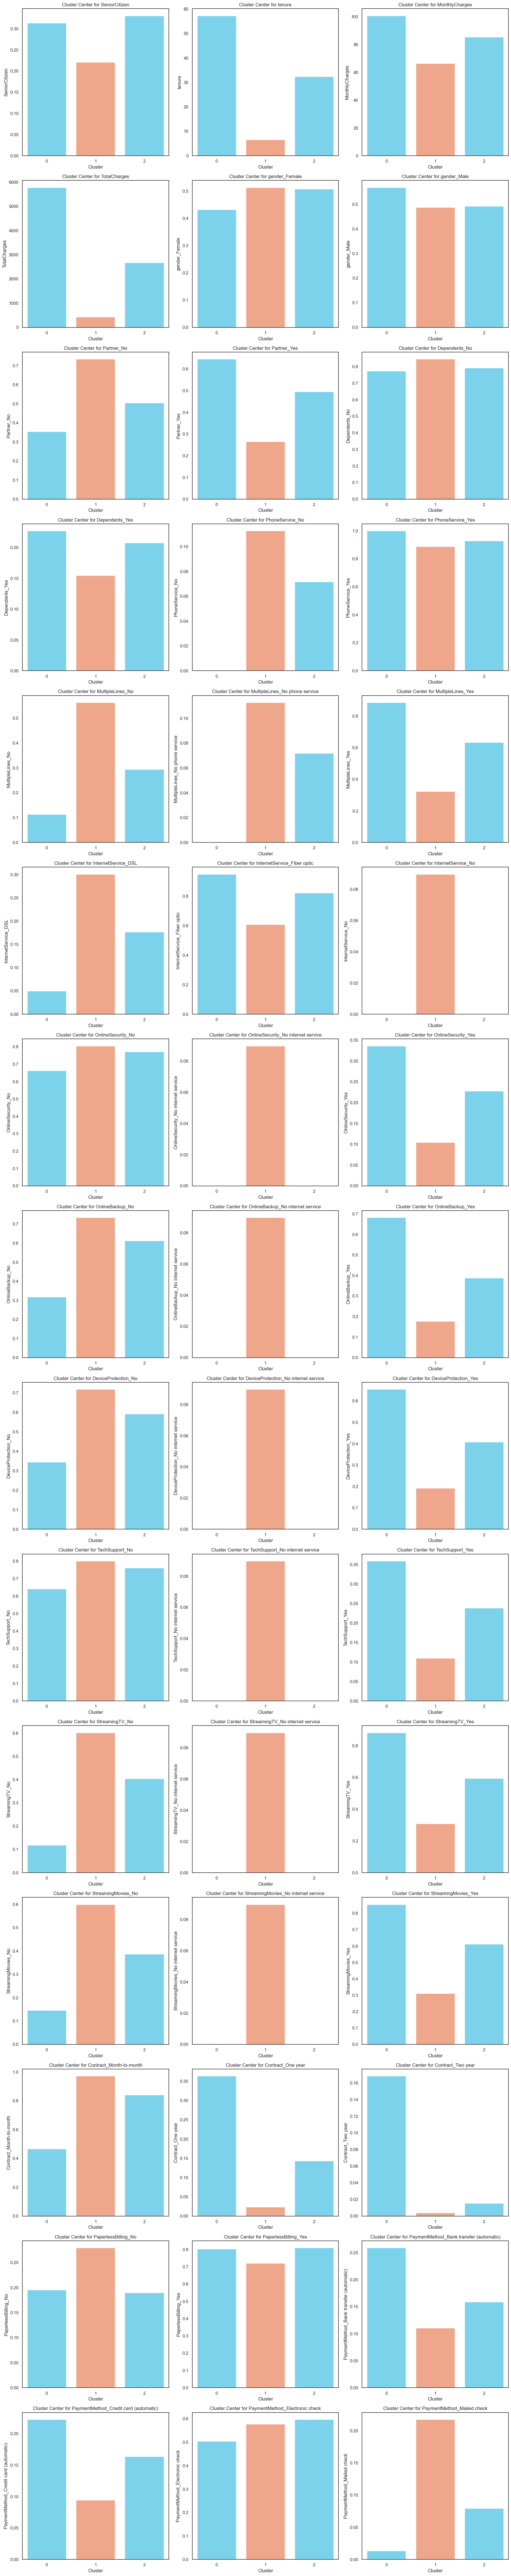

In [42]:
# Selected features for visualization
features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

# Extract cluster centers for selected features
cluster_centers_df_selected = cluster_centers_df[features + ['Cluster']]

# Calculate number of rows and columns for subplots
num_features = len(features)
num_cols = 3  # Number of columns per row
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create subplots for each selected feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))

# Flatten axes if necessary (for handling 1D array when num_rows == 1)
axes = axes.flatten() if num_rows > 1 else [axes]

for i, feature in enumerate(features):
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.barplot(x='Cluster', y=feature, data=cluster_centers_df_selected, ax=axes[i], palette=custom_palette)
    axes[i].set_title(f'Cluster Center for {feature}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)
    plt.savefig(f'Cluster_Center_{feature}.png')

# Remove any extra subplots that are not used
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [33]:
from sklearn.decomposition import PCA
# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

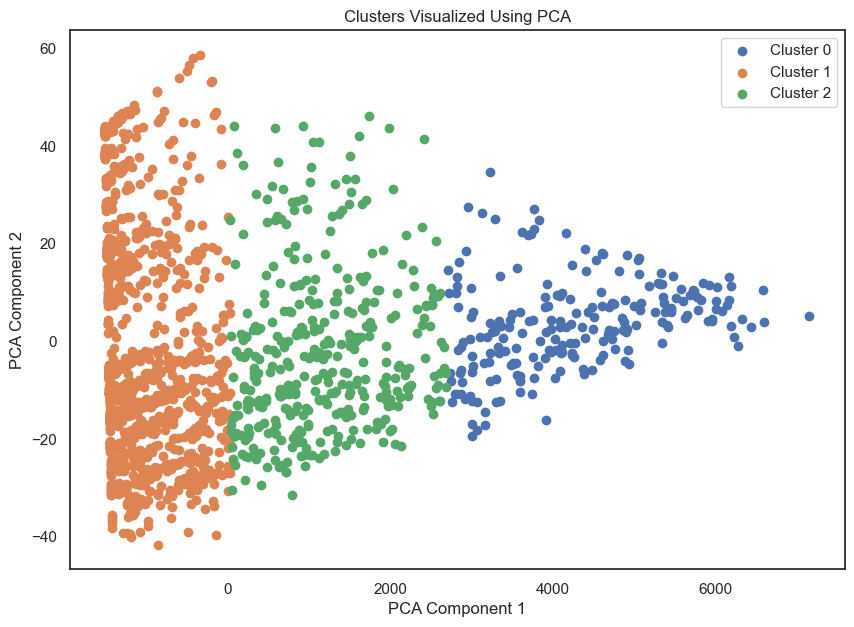

In [34]:
# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in np.unique(clusters):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f'Cluster {cluster}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualized Using PCA')
plt.legend()
plt.show()

In [35]:
# Get the loadings to see which features contribute to PC1 and PC2
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=X_cluster.columns)

print(loadings_df)

                                              PC1       PC2
SeniorCitizen                            0.000023 -0.002317
tenure                                   0.009854  0.141872
MonthlyCharges                           0.007120 -0.989179
TotalCharges                             0.999926  0.005652
gender_Female                           -0.000013 -0.001175
gender_Male                              0.000013  0.001175
Partner_No                              -0.000080 -0.000330
Partner_Yes                              0.000080  0.000330
Dependents_No                           -0.000015 -0.001563
Dependents_Yes                           0.000015  0.001563
PhoneService_No                         -0.000022  0.006568
PhoneService_Yes                         0.000022 -0.006568
MultipleLines_No                        -0.000093  0.002092
MultipleLines_No phone service          -0.000022  0.006568
MultipleLines_Yes                        0.000115 -0.008660
InternetService_DSL                     

# Final Model

In [36]:
# Imagine this is new data we want to predict and cluster
new_data = df_dummies.copy().drop('Churn', axis=1)

In [37]:
# Predict probabilities for churn
churn_probabilities = best_model.predict_proba(new_data)[:, 1]

# Predict churn status (binary prediction based on threshold, e.g., 0.5)
predicted_churn = (churn_probabilities > 0.5).astype(int)

# Filter new_data to include only predicted churners
new_data_churners = new_data[predicted_churn == 1]

# Predict clusters for churners
churner_clusters = kmeans.predict(new_data_churners)

# Add predicted clusters back to the original dataframe for churners
new_data_churners['Cluster'] = churner_clusters



C:\Users\Janika\AppData\Local\Temp\ipykernel_16028\761539926.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_churners['Cluster'] = churner_clusters


In [38]:
new_data_churners

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Cluster
0,0,1,29.85,29.85,True,False,False,True,True,False,...,True,False,False,False,True,False,False,True,False,1
4,0,2,70.70,151.65,True,False,True,False,True,False,...,True,False,False,False,True,False,False,True,False,1
5,0,8,99.65,820.50,True,False,True,False,True,False,...,True,False,False,False,True,False,False,True,False,1
20,1,1,39.65,39.65,False,True,True,False,True,False,...,True,False,False,False,True,False,False,True,False,1
27,0,1,30.20,30.20,False,True,False,True,False,True,...,True,False,False,True,False,False,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7010,1,1,74.45,74.45,True,False,False,True,True,False,...,True,False,False,False,True,False,False,True,False,1
7016,0,1,49.95,49.95,True,False,True,False,True,False,...,True,False,False,True,False,False,False,True,False,1
7018,0,1,70.65,70.65,False,True,False,True,False,True,...,True,False,False,False,True,False,False,False,True,1
7032,1,1,75.75,75.75,False,True,True,False,True,False,...,True,False,False,False,True,False,False,True,False,1


### Ausgewählte Attribute der Cluster als RadarChart

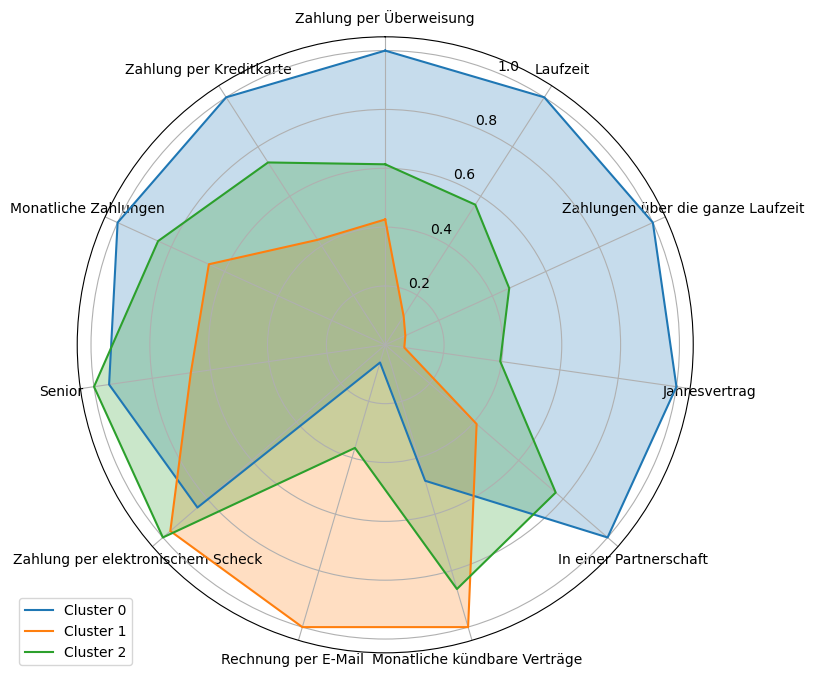

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Beispiel-Daten vorbereiten
data = {
    'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2'],
    
    
    'Zahlung per Überweisung': [0.259091, 0.110405, 0.158974],
    'Laufzeit': [57.286364, 6.632248, 32.435897],
    'Zahlungen über die ganze Laufzeit': [5780.754318, 434.219500, 2678.150256], 
    
    'Jahresvertrag': [0.363636, 0.023828, 0.143590],
    'In einer Partnerschaft': [0.645455, 0.265290, 0.494872],
    'Monatliche kündbare Verträge': [0.468182, 0.972200, 0.841026],
    'Rechnung per E-Mail': [0.013636, 0.217633, 0.079487],
    #'Contract_Two year': [0.168182, 0.003971, 0.015385],
    'Zahlung per elektronischem Scheck': [0.504545, 0.577442, 0.597436],
    
    
    # Andere
    #'PaperlessBilling_Yes': [0.804545, 0.720413, 0.810256],
    'Senior': [0.313636, 0.220810, 0.330769],
    'Monatliche Zahlungen': [100.765, 66.408022, 85.525256],
    
    'Zahlung per Kreditkarte': [0.222727, 0.094519, 0.164103]
    
    
    #'gender_Female': [0.431818, 0.513106, 0.507692],
    #'gender_Male': [0.568182, 0.486894, 0.492308],
    #'Partner_No': [0.354545, 0.734710, 0.505128],
    #'Dependents_No': [0.772727, 0.845115, 0.792308],
    #'Dependents_Yes': [0.227273, 0.154885, 0.207692],
    #'PaperlessBilling_No': [0.195455, 0.279587, 0.189744],
    #'PaperlessBilling_Yes': [0.804545, 0.720413, 0.810256],
    #'PaymentMethod_Bank transfer (automatic)': [0.259091, 0.110405, 0.158974],
    #'PaymentMethod_Credit card (automatic)': [0.222727, 0.094519, 0.164103],
    #'PaymentMethod_Electronic check': [0.504545, 0.577442, 0.597436],
    

}

df = pd.DataFrame(data)

# Skalieren der Daten
scaled_df = df.copy()
for col in df.columns[1:]:
    scaled_df[col] = df[col] / df[col].max()

# Radar Chart erstellen
labels = scaled_df.columns[1:]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in scaled_df.iterrows():
    values = row.drop('Cluster').tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['Cluster'])
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()
